# Annealed sinkhorn for Optimal Transport

In this tutorial, we explore the various recipes proposed in [Chizat, 2024](https://arxiv.org/abs/2408.11620) to accelerate the convergence of sinkhorn algorithm, striking a better tradeoff between accuracy and speed of convergence  

This tutorial was elaborated by HEZBRI Nour 
-Email : nour.hezbri@ensae.fr to validate the course Computational Optimal transport of Marco CUTURI.

## Imports

In [1]:
import os 
import sys

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, "../../src"))
sys.path.insert(0, src_path)

In [2]:
import jax.numpy as jnp
from ott.geometry import pointcloud, costs
from ott.solvers.linear import sinkhorn
import seaborn as sns
import matplotlib.pyplot as plt
from ott.problems.linear import linear_problem
import jax 
import time 
from ott.geometry.epsilon_scheduler import Epsilon
import jax.tree_util as jtu
from typing import Optional
import jax.numpy as jnp
from ott.geometry import geometry
import ot 


## Problem Formulation

All along, we are interested in solving the **entropy-regularized optimal transport problem** (EOT) formulated as:

$$
EOT_{\beta}(p, q) := \min_{\pi \in \Gamma(p, q)} \langle c, \pi \rangle + \frac{1}{\beta} \text{KL}(\pi \parallel \pi_{\text{ref}})
$$

Where:
- $ p \in \Delta^m $, $ q \in \Delta^n $: input marginal distributions (probability vectors),
- $ c \in \mathbb{R}^{m \times n} $: cost matrix,
- $ \Gamma(p, q) = \left\{ \pi \in \mathbb{R}_+^{m \times n} : \pi 1 = p, \pi^\top 1 = q \right\} $: set of admissible couplings,
- $ \beta > 0 $: inverse temperature (i.e., regularization strength $ \epsilon = \frac{1}{\beta} $),
- $ \text{KL}(\pi \parallel \pi_{\text{ref}}) $: Kullback-Leibler divergence,
- $ \pi_{\text{ref}} = \frac{1}{mn} 1_m 1_n^\top $: uniform reference coupling.

This problem is efficiently solved using the **Sinkhorn algorithm**.


The unique solution $ \pi^* $ to the EOT problem has the form:

$$
\pi^* = \text{diag}(a^*) \, K \, \text{diag}(b^*)
$$

Where:
- $ K = \exp(-\beta c) \in \mathbb{R}_+^{m \times n} $ is the **Gibbs kernel**,
- $ a^* \in \mathbb{R}_+^m $, $ b^* \in \mathbb{R}_+^n $ are the **scaling vectors**.

Starting from initial vectors $ a_0 = 1 $, $ b_0 = 1 $, Sinkhorn’s algorithm performs alternating KL projections  onto the marginal constraints.

The update rules are:

$$
a_t = \frac{p}{K b_{t-1}} \quad \text{and} \quad b_t = \frac{q}{K^\top a_t} 
$$

An important question is how to choose the value of **β** to get the best balance between **accuracy**, **convergence speed**, and **numerical stability**.  
To address this, we explore several practical strategies, all based on implementing an **annealing approach** — where **β** is not fixed, but instead follows a varying sequence $(\beta_t)_t$ over time.


<!-- An important question is on how to choose beta, to strike the best tradeoff between accuracy and speed of convergence and stability of the algorithm. 
Therefore, we explore here several recipes for that , all of them based on the implementation of an annealing strategy, by considering a varying $(\beta_t)_t$ sequence over time.  -->

<!-- ## 📉 Annealing Strategy: \( \beta_t \) Schedule

To reduce bias from entropy regularization, an **annealing schedule** increases \( \beta \) over time:

$$
\epsilon_t = \frac{1}{\beta_t} \quad \rightarrow \quad 0
$$

This defines a **regularization path** from a highly regularized problem to the true OT solution.

### Behavior over time:

- **Early stages (small \( \beta \) / large \( \epsilon \))**:
  - Fast convergence,
  - Regularized solution is overly smooth, introducing bias.

- **Later stages (large \( \beta \) / small \( \epsilon \))**:
  - Slower convergence,
  - Solution approximates the true OT more accurately but with slower convergence.

This schedule is akin to **simulated annealing**, where:
- Early iterations explore a broad space of solutions,
- Later iterations focus on refining the solution for more precise results. -->

<!-- Entropic Optimal transport : 

Entropic OT formulation :  

write as an introduction 

+ motivation: in what context/setting we want to resort to an annealing scheme :

+ how much we gain presomptly in speed of convergence: which is exactly what we want to experiment in this notebook for different choices of cost and data settings 
We will explore 4 different recipes . with the gain in complexity we have with EOT, the question remains on how to efficiently choose the hyperparameter epsilon, the blurring param, so as to go fast , but not loose too much in terms of the error on the solution. depending on the complexity of the data we aim to transport, we might want to adopt an annealing strategy, basically we start with higher values of epsilon in the beginning and then to decrese it gradually so to refine .


we will look at different recipes for a simple synthetic data steup and at the end we will provide a comparison   -->

## 1- Schedule definition : 

<!-- The schedule proposed in the paper is of the form \beta_t= \beta_0()

properties : concave 
\beta_t -> inf 
\beta_t -\betat-1 -> 0 -->


We consider a **positive, non-decreasing, and concave** annealing schedule $ (\beta_t)$, which satisfies the following properties:

- **Monotonicity**:  
  $ \beta_t \geq \beta_{t-1} $ (i.e., the sequence is non-decreasing).

- **Concavity**:  
  The sequence of differences $ \alpha_t = \beta_t - \beta_{t-1} $ is **non-negative and non-increasing**.

- **Unbounded growth**:  
  $\beta_t \to \infty $ as $ t \to \infty $.

- **Vanishing increments**:  
  $ \beta_t - \beta_{t-1} \to 0 $ as $  t \to \infty $.

The paper proposes a specific schedule of the form:

$$
\beta_t = \beta_0 \cdot (1+t)^\kappa
$$

In [3]:
@jtu.register_pytree_node_class

class PolynomialEpsilon(Epsilon):
    """
    Polynomial decay scheduler: epsilon_it = (it+1)^(-kappa) * target
    """
    def __init__(self, target: jnp.ndarray, kappa: float, init: float = 1.0):
        super().__init__(target=target, init=init, decay=1.0)
        self.kappa = kappa

    def __call__(self, it: Optional[int]) -> jnp.ndarray:
        if it is None:
            return self.target
        multiple = ((it + 1) ** (-self.kappa))
        return multiple * self.target

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(target={self.target}, kappa={self.kappa},"
            f" init={self.init})"
        )

To track and study the suboptimality of the solution at each step, we use the following **projection-based function** — a method originally proposed in [Altschuler et al.] and also adopted in the paper to monitor convergence.



In [4]:
def projection_plan(p: jnp.ndarray, q: jnp.ndarray, gamma: jnp.ndarray) -> jnp.ndarray:
    """Projection algorithm to enforce marginal constraints  by Altschuler et al.."""
    a = jnp.minimum(p / jnp.sum(gamma, axis=1), 1.0)
    gamma_temp = a[:, None] * gamma
    b = jnp.minimum(q / jnp.sum(gamma_temp, axis=0), 1.0)
    gamma_temp = gamma_temp * b[None, :]
    delta_p = p - jnp.sum(gamma_temp, axis=1)
    delta_q = q - jnp.sum(gamma_temp, axis=0)
    gamma_plan = gamma_temp + jnp.outer(delta_p, delta_q) / jnp.sum(delta_p)
    return gamma_plan


## Data 

<!-- We define the geometry we will consider , and in particular , we take 2 different setups, one with a structured cost (euclidean):= 
the second with an unstructured cost : to track the behaviour of the algo in a sort of worst case setup. -->

We define the geometric setups used in our experiments, considering two different cost structures:

1. **Structured cost (Euclidean)**:  
   We use the standard squared Euclidean distance  
   $ c(x_i, y_j) = \|x_i - y_j\|_2^2 $.

2. **Unstructured cost**:  
   We generate a random cost matrix to simulate a kind of worst-case scenario, allowing us to observe the algorithm's behavior under less favorable conditions.


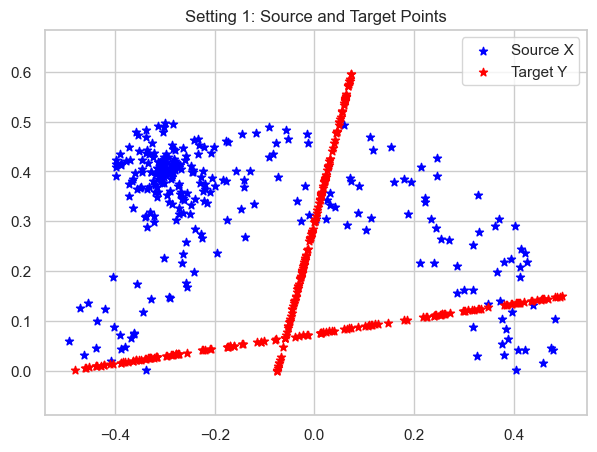

Exact Optimal Transport cost: 0.077764


In [5]:
# ---------- Setting 1: structured cost : example from the paper ----------
# Set Seaborn style
sns.set(style="whitegrid")
key = jax.random.PRNGKey(1)
# Source X 
m = 144
ang = jax.random.uniform(key, (m,)) * jnp.pi; key, sub = jax.random.split(key)
rad = jax.random.uniform(sub, (m,)) * 0.2 + 0.3; key, sub = jax.random.split(key)
X1 = jnp.stack([rad * jnp.cos(ang), rad * jnp.sin(ang)], axis=1)

ang2 = jax.random.uniform(sub, (m,)) * 2 * jnp.pi; key, sub = jax.random.split(key)
rad2 = jax.random.uniform(sub, (m,)) * 0.1
X2 = jnp.stack([rad2 * jnp.cos(ang2) - 0.3, rad2 * jnp.sin(ang2) + 0.4], axis=1)

X = jnp.concatenate([X1, X2], axis=0)

# Plot source points (X) in blue
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Source X', marker='*')

# Target Y 
n = 144
key, sub = jax.random.split(key)
Y1 = jnp.stack([jax.random.uniform(sub, (n,)) - 0.5,
                jax.random.uniform(sub, (n,)) * 0.15], axis=1)
key, sub = jax.random.split(key)
Y2 = jnp.stack([(jax.random.uniform(sub, (n,)) - 0.5) * 0.15,
                jax.random.uniform(sub, (n,)) * 0.6], axis=1)

Y = jnp.concatenate([Y1, Y2], axis=0)

# Plot target points (Y) in red
plt.scatter(Y[:, 0], Y[:, 1], color='red', label='Target Y', marker='*')

# Add legend and axis settings
plt.legend()
plt.title('Setting 1: Source and Target Points')
plt.axis('equal')
plt.show()

# Now defining p and q as uniform distributions over the source and target points
p1 = jnp.ones(X.shape[0]) / X.shape[0]
q1 = jnp.ones(Y.shape[0]) / Y.shape[0]

# Compute the cost matrix c1 (Euclidean distance)
diff = X[:, None, :] - Y[None, :, :]
c1 = jnp.sum(diff**2, axis=2)
c1 = (c1 - jnp.min(c1)) / (jnp.max(c1) - jnp.min(c1))

# Create geometry object
geom1 = pointcloud.PointCloud(X, Y, cost_matrix=c1)

# Define the linear problem
prob1 = linear_problem.LinearProblem(geom1, a=p1, b=q1)

# Use `ot.emd2` to compute the optimal transport cost
cost_exact_1= ot.emd2(p1, q1, c1)  # cost (transport distance)
plans_exact_1 = ot.emd(p1, q1, c1)  # transport plan

# Output the results
print(f"Exact Optimal Transport cost: {cost_exact_1:.6f}")

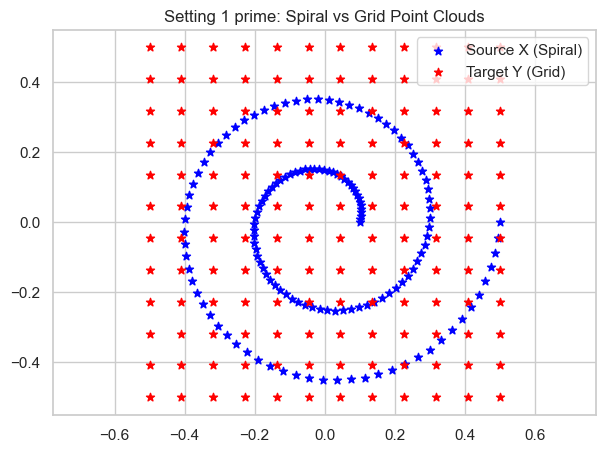

Exact Optimal Transport cost: 0.017582


In [6]:

# Set Seaborn style
sns.set(style="whitegrid")

# ---------- Setting 1: Spiral vs Grid : structured cost ----------

# Master key and subkey split
master_key = jax.random.PRNGKey(42)
key_spiral, key_grid = jax.random.split(master_key, 2)

# Source X: Spiral
m = 144
theta = jnp.linspace(0, 4 * jnp.pi, m)
r = jnp.linspace(0.1, 0.5, m)
X = jnp.stack([r * jnp.cos(theta), r * jnp.sin(theta)], axis=1)

# Target Y: Grid
n = 144
grid_size = int(jnp.sqrt(n))
x_vals = jnp.linspace(-0.5, 0.5, grid_size)
y_vals = jnp.linspace(-0.5, 0.5, grid_size)
Xv, Yv = jnp.meshgrid(x_vals, y_vals)
Y = jnp.stack([Xv.ravel(), Yv.ravel()], axis=1)

# Plot source and target
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Source X (Spiral)', marker='*')
plt.scatter(Y[:, 0], Y[:, 1], color='red', label='Target Y (Grid)', marker='*')
plt.legend()
plt.title('Setting 1 prime: Spiral vs Grid Point Clouds')
plt.axis('equal')
plt.show()

# Uniform distributions over X and Y
p12 = jnp.ones(X.shape[0]) / X.shape[0]
q12 = jnp.ones(Y.shape[0]) / Y.shape[0]

# Compute normalized cost matrix (squared Euclidean)
diff2 = X[:, None, :] - Y[None, :, :]  # shape (m, n, 2)
c12 = jnp.sum(diff2**2, axis=2)
c12 = (c12 - jnp.min(c12)) / (jnp.max(c12) - jnp.min(c12))  # proper normalization to [0,1]

# Geometry and linear problem definition
geom12 = pointcloud.PointCloud(X, Y, cost_matrix=c12, epsilon=1e-8)
prob12 = linear_problem.LinearProblem(geom12, a=p12, b=q12)

# Exact OT computation (Sinkhorn regularization off (beta = ∞))
cost_exact_12 = ot.emd2(p12, q12, c12)
plans_exact_12 = ot.emd(p12, q12, c12)

print(f"Exact Optimal Transport cost: {cost_exact_12:.6f}")


In [7]:
# ---------- Setting 2: Unstructured Random Cost ----------
master_key = jax.random.PRNGKey(1)
key_p, key_q, key_c = jax.random.split(master_key, 3)
m, n = 144, 144

# Generate random probability distributions p and q
p2 = jax.random.uniform(key_p, (m,))
q2 = jax.random.uniform(key_q, (n,))
p2 /= jnp.sum(p2)
q2 /= jnp.sum(q2)

# Random cost matrix, normalized
c2 = jax.random.normal(key_c, (m, n))
c2 = (c2 - jnp.min(c2)) / (jnp.max(c2) - jnp.min(c2))

# Create the geometry object with the random cost
geom2 = geometry.Geometry(cost_matrix=c2)

# Baseline : exact OT computation (beta = ∞)
cost_exact_2 = ot.emd2(p2, q2, c2)
plans_exact_2 = ot.emd(p2, q2, c2)

print(f"Exact Optimal Transport cost: {cost_exact_2:.6f}")

Exact Optimal Transport cost: 0.266252


## Annealed Sinkhorn- Debiased annealed Sinkhorn

<!-- As highlighted the basic block is the schedule, but since we dont use the same regularization size at each step, this creates a bias
which we could mitigate by slightly modifying the iterates expression as the following.


followingly we test, showcase that on both examples, for biased and debiased . 

we use herein the previously defined projection fct : indeed and explain ... -->

As highlighted earlier, the core component of the recipes we will be exploring is the **annealing schedule**. However, since the regularization strength (i.e., $\beta_t$) varies across iterations, this introduces a **bias** in the resulting transport plans.

To address this, an alternative could be to apply a slight modification to the update rule, leading to a **debiased version** of the algorithm.


 ⚙️ Algorithm 3: Debiased Annealed Sinkhorn (from the paper) 

**Input:**  
- Probability vectors $p \in \Delta^*_m$, $q \in \Delta^*_n$  
- Cost matrix $c \in \mathbb{R}^{m \times n}$  
- Annealing schedule $(\beta_t)_{t \geq 0}$

**Initialize:**  
- $b_0 = \mathbf{1} \in \mathbb{R}^n$  
- $K_0 = \exp(-\beta_0 \cdot c) \in \mathbb{R}^{m \times n}$

**For** $t = 1, 2, 3, \dots$:

1. **Update scaling factor:**

$$
a_t = \left( a_{t-1}^{1 - \frac{\beta_{(t−2)\vee 0}}{\beta_{t−1}}} \odot p \right) \oslash (K_{t-1} b_{t-1})
$$

*Debiasing is introduced via the exponent term.*

2. **Update kernel:**

$$
K_t = \exp(-\beta_t \cdot c)
$$

3. **Update scaling vector:**

$$
b_t = q \oslash (K_t^\top a_t)
$$

4. **Compute transport plan:**

$$
\pi_t = \text{diag}(a_t) \cdot K_t \cdot \text{diag}(b_t)
$$


Followingly, we will test both the vanilla annealed scheme and the debiased variant on both setups — **structured** and **unstructured** cost.

In [8]:
def sinkhorn_track(
    p: jnp.ndarray,
    q: jnp.ndarray,
    c: jnp.ndarray,
    niter: int = 100,
    eps_sched : PolynomialEpsilon=None,
    OT_cost: float = 0.0,
    kappa: float = 0.0,
    beta0: float = 1.0,
    debiased: bool = True,
    iter_stop: int = None,
    plateau_length: int = 1,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Annealed Sinkhorn algorithm with tracking."""
    m, n = p.shape[0], q.shape[0]
    if iter_stop is None:
        iter_stop = niter

    u, v = jnp.zeros(m), jnp.zeros(n)
    lp, lq = jnp.log(p), jnp.log(q)
    plans = jnp.zeros((niter, m, n))
    err = jnp.zeros((niter,))
    beta = beta0

    for t in range(niter):
        if debiased and (t < iter_stop):
            inv_eps_prev = 1.0 / eps_sched(t-1) if t > 0 else 0.0
            deb_term = (1/ eps_sched(t) -inv_eps_prev) / (1/ eps_sched(t)) * u
            temp1 = (lq + v - beta * c) - deb_term[:, None]
        else:
            temp1 = v + lq - beta * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        u = -stab1.flatten() - jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1))

        if (t < iter_stop) and (int(jnp.floor(jnp.sqrt(t + 1))) % plateau_length == 0):
            beta = 1/eps_sched(t+1)

        temp2 = u[:, None] + lp[:, None] - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        v = -stab2.flatten() - jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0))

        plan = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c)
        plan_proj = projection_plan(p, q, plan)
        plans = plans.at[t].set(plan_proj)
        err = err.at[t].set(jnp.sum(c * plan_proj) - OT_cost)

    return plans, err

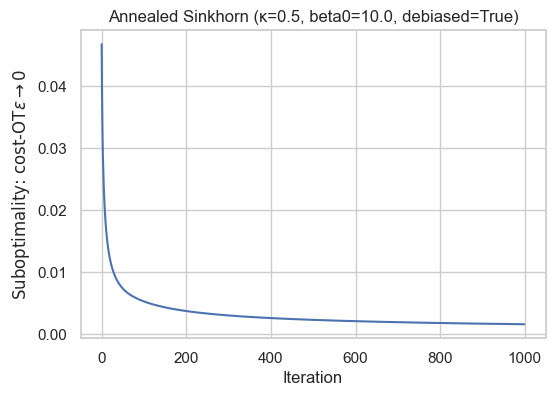

In [12]:
import ipywidgets as widgets
from IPython.display import display , clear_output


sns.set(style="whitegrid")
kappa = 0.5           
beta_0 = 10.0  
niter=1000

# Widget for choosing setting and debiasing
setting_widget = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2),('Geometric point cloud (spiral to grid)', 3) ],
    value=1,
    description='Setting:'
)
deBias_widget = widgets.Checkbox(
    value=False,
    description='Debiased'
)

# Function to run sinkhorn_track and return error curve
def run_track(setting, debiased):
    if setting == 1:
        p, q, c, OT_cost = p1, q1, c1, cost_exact_1
    elif setting == 2:
        p, q, c, OT_cost = p2, q2, c2, cost_exact_2
    else :
        p, q, c, OT_cost = p12, q12, c12, cost_exact_12
    eps_sched = PolynomialEpsilon(target=jnp.array(1.0 / beta_0), kappa=kappa)
    _, err = sinkhorn_track(
        p, q, c,
        niter=niter,
        eps_sched=eps_sched,
        debiased=debiased,
        OT_cost=OT_cost,
        beta0=beta_0,
        kappa=kappa
    )
    return err

# Plot static suboptimality curve
def plot_error(err, setting, debiased):
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=jnp.arange(len(err)), y=err)
    plt.title(f"Annealed Sinkhorn (κ={kappa}, beta0={beta_0}, debiased={deBias_widget.value})")
    plt.xlabel("Iteration")
    plt.ylabel(r"$\text{Suboptimality: cost-}  \text{OT}{\epsilon \to 0}$")
    plt.grid(True)
    plt.show()

# Button to trigger computation and plot
toggle_button = widgets.Button(description="Run and Plot")


def on_toggle_clicked(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_widget, deBias_widget, toggle_button]))
    err = run_track(setting_widget.value, deBias_widget.value)
    plot_error(err, setting_widget.value, deBias_widget.value)

toggle_button.on_click(on_toggle_clicked)

# Display the widgets and output area
display(widgets.HBox([setting_widget, deBias_widget, toggle_button]))

## Symmetric sinkhorn  

An important limitation of Sinkhorn’s algorithm is that, after a finite number of iterations, the output transport plan $\pi_t$ can be **asymmetric** with respect to $p$ and $q$ — meaning it may satisfy only one of the marginal constraints exactly, while the other remains off. This asymmetry can be problematic or undesirable in certain applications where balanced or fully satisfied marginals are crucial, which motivated the symmetric variant of Sinkhorn. 
Here, we look at the symmetric variant of the previously discussed annealed scheme.


⚙️ Algorithm 4: Debiased Annealed Symmetric Sinkhorn  
*(For the non-debiased version, set the exponents in red to 0)*

**Input:**  
- Probability vectors $p \in \Delta^*_m$, $q \in \Delta^*_n$  
- Cost matrix $c \in \mathbb{R}^{m \times n}$  
- Annealing schedule $(\beta_t)_{t \geq 0}$

**Initialize:**  
- $a_0 = \mathbf{1} \in \mathbb{R}^m$  
- $b_0 = \mathbf{1} \in \mathbb{R}^n$  
- $K_0 = \exp(-\beta_0 \cdot c) \in \mathbb{R}^{m \times n}$

**For** $t = 1, 2, 3, \dots$:

1. **Update scaling vectors:**

$$
a_t = \left(a_{t-1}^{\frac{1}{2} + \left(1 - \frac{\beta_{(t-2) \vee 0}}{\beta_{t-1}}\right)} \odot \left(\frac{p}{K_{t-1} b_{t-1}}\right)^{\frac{1}{2}} \right)
$$

$$
b_t = \left(b_{t-1}^{\frac{1}{2} + \left(1 - \frac{\beta_{(t-2) \vee 0}}{\beta_{t-1}}\right)} \odot \left(\frac{q}{K_{t-1}^\top a_{t-1}}\right)^{\frac{1}{2}} \right)
$$

2. **Update kernel with new temperature:**

$$
K_t = \exp(-\beta_t \cdot c)
$$

3. **Compute transport plan (projected onto the simplex):**

$$
\pi_t = \text{normalize}\left(\text{diag}(a_t) \cdot K_t \cdot \text{diag}(b_t)\right)
$$



In [10]:
def symmetric_sinkhorn_track(
    p: jnp.ndarray,
    q: jnp.ndarray,
    c: jnp.ndarray,
    niter: int = 100,
    OT_cost: float = 0.0,
    kappa: float = 0.0,
    beta0: float = 1.0,
    debiased: bool = True,
    iter_stop: int | None = None,
    plateau_length: int = 1,
    eps_sched : PolynomialEpsilon=None
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Symmetric Annealed Sinkhorn  with projection.
    """
    m, n = p.shape[0], q.shape[0]
    iter_stop = niter if iter_stop is None else iter_stop
    u = jnp.zeros(m)
    v = jnp.zeros(n)
    lp = jnp.log(p)
    lq = jnp.log(q)

    plans = jnp.zeros((niter, m, n))
    err = jnp.zeros(niter)
    beta = beta0

    for t in range(niter):
        inv_eps_prev = 1.0 / eps_sched(t-1) if t > 0 else 0.0
        theta = (1 - (inv_eps_prev)/(1 / eps_sched(t))) if debiased else 0.0
        # first potential update
        temp1 = v - beta * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        u = (0.5 + theta)*u + 0.5*lp - 0.5*(stab1.flatten() + jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1)))
        # second potential update
        temp2 = u - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        v = (0.5 + theta)*v + 0.5*lq - 0.5*(stab2.flatten() + jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0)))

        # plan and normalize
        plan = jnp.exp(u[:, None] + v[None, :] - beta * c)
        plan = plan / jnp.sum(plan)
        plan_proj = projection_plan(p, q, plan)

        plans = plans.at[t].set(plan_proj)
        err = err.at[t].set(jnp.sum(c * plan_proj) - OT_cost)

        # schedule update
        if (t < iter_stop) and (int(jnp.floor(jnp.sqrt(t + 1))) % plateau_length == 0):
            beta = 1 / eps_sched(t+1)

    return plans, err

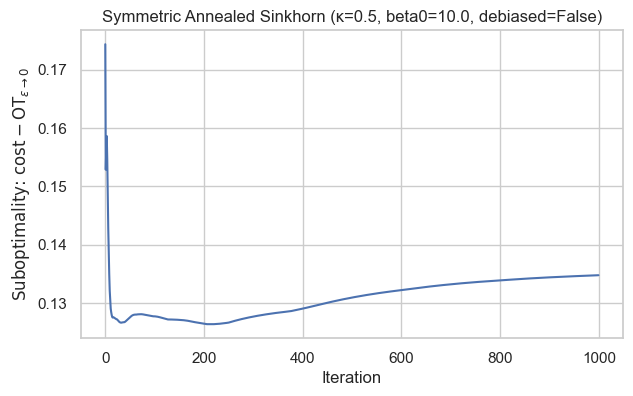

In [13]:
sns.set(style="whitegrid")

# Widgets for selecting setting and toggling debiasing
setting_widget = widgets.Dropdown(
    options=[('Geometric point cloud(paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
debiased_widget = widgets.Checkbox(
    value=False,
    description='Debiased'
)
run_button = widgets.Button(description="Run Symmetric Sinkhorn")
# output = widgets.Output()

def run_and_plot(_: widgets.Button):

    clear_output(wait=True)
    display(widgets.HBox([setting_widget, debiased_widget, run_button]))
    # Pick the right data
    if setting_widget.value == 1:
        p, q, c, OT_cost = p1, q1, c1, cost_exact_1
    elif setting_widget.value == 2:
        p, q, c, OT_cost = p2, q2, c2, cost_exact_2
    else :
        p, q, c, OT_cost = p12, q12, c12, cost_exact_12

    # Build epsilon schedule
    eps_sched = PolynomialEpsilon(target=jnp.array(1.0 / beta_0), kappa=kappa)

    # Run symmetric Sinkhorn track
    plans, err = symmetric_sinkhorn_track(
        p=p, q=q, c=c,
        niter=niter,
        OT_cost=OT_cost,
        kappa=kappa,
        beta0=beta_0,
        debiased=debiased_widget.value,
        eps_sched=eps_sched
    )

    # Plot suboptimality
    plt.figure(figsize=(7, 4))
    sns.lineplot(x=jnp.arange(niter), y=err)
    plt.title(f"Symmetric Annealed Sinkhorn (κ={kappa}, beta0={beta_0}, debiased={debiased_widget.value})")
    plt.xlabel("Iteration")
    plt.ylabel(r"$\text{Suboptimality: cost} - \text{OT}_{\epsilon \to 0}$")
    plt.grid(True)
    plt.show()

run_button.on_click(run_and_plot)

display(widgets.HBox([setting_widget, debiased_widget, run_button]))

## Comparison 

### 1- Pareto curves 



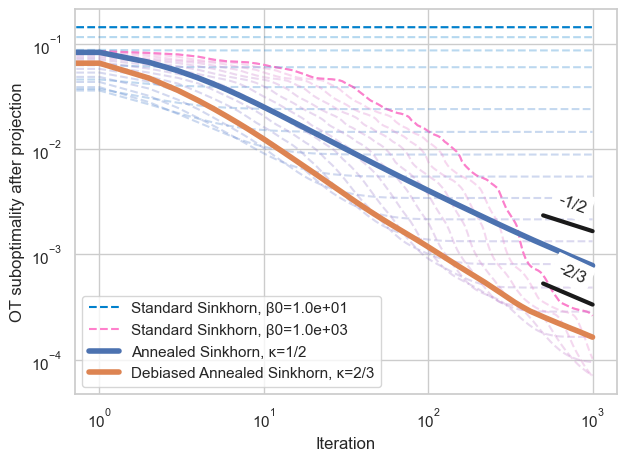

In [16]:
sns.set(style="whitegrid")
# 1) Setting selector widget
setting_pf = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_pf_button = widgets.Button(description="Run Pareto Front")

# 2) Callback
def run_pareto_front(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_pf, run_pf_button]))
    # choose the correct data
    if setting_pf.value == 1:
        p_exp, q_exp, c_exp, OT_cost_exp = p1, q1, c1, cost_exact_1
    elif setting_pf.value == 2:
        p_exp, q_exp, c_exp, OT_cost_exp = p2, q2, c2, cost_exact_2
    else :
        p_exp, q_exp, c_exp, OT_cost_exp = p12, q12, c12, cost_exact_12

    # rest of your code exactly as before…
    niter_pf = 1000
    beta0_pf = 10.0
    eps_sched_12 = PolynomialEpsilon(target=jnp.array(1.0 / beta0_pf), kappa=0.5)
    eps_sched_23 = PolynomialEpsilon(target=jnp.array(1.0 / beta0_pf), kappa=2/3)
    

    _, err_12 = sinkhorn_track(
        p_exp, q_exp, c_exp,
        niter=niter_pf, OT_cost=OT_cost_exp,
        kappa=0.5, beta0=beta0_pf, debiased=False,
        eps_sched=eps_sched_12
    )
    _, err_23 = sinkhorn_track(
        p_exp, q_exp, c_exp,
        niter=niter_pf, OT_cost=OT_cost_exp,
        kappa=2/3, beta0=beta0_pf, debiased=True,
        eps_sched=eps_sched_23
    )

    betas = jnp.logspace(1, 3, num=21)
    err_tab = jnp.zeros((niter_pf, betas.shape[0]))
    for idx, b0 in enumerate(betas):
        eps_sched_0 = PolynomialEpsilon(target=jnp.array(1.0 / b0), kappa=0.0)
        _, e = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_pf, OT_cost=OT_cost_exp,
            kappa=0.0, beta0=b0, debiased=True,
            eps_sched=eps_sched_0
        )
        err_tab = err_tab.at[:, idx].set(e)

    plt.figure(figsize=(7,5))
    plt.loglog(err_tab[:, 0], '--', color=(0/len(betas), 0.5, 0.8),label=f'Standard Sinkhorn, β0={betas[0]:.1e}')
    plt.loglog(err_tab[:, -1], '--',color=(1, 0.5, 0.8), label=f'Standard Sinkhorn, β0={betas[-1]:.1e}')
    for idx in range(betas.shape[0]):
        plt.loglog(err_tab[:, idx], '--', color=(idx/len(betas), 0.5, 0.8), alpha=0.3)
    plt.loglog(err_12, label='Annealed Sinkhorn, κ=1/2', lw=4)
    plt.loglog(err_23, label='Debiased Annealed Sinkhorn, κ=2/3', lw=4)

    iters = jnp.arange(500, niter_pf+1, 10)
    plt.text(600, 2.5e-3, '-1/2', backgroundcolor='white', rotation=-20)
    plt.plot(iters, iters**(-1/2)/19, 'k', lw=3)
    plt.text(600, 5.4e-4, '-2/3', backgroundcolor='white', rotation=-25)
    plt.plot(iters, iters**(-2/3)/30, 'k', lw=3)

    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('OT suboptimality after projection')
    plt.grid(True)
    plt.show()

# 3) Wire it up and display
run_pf_button.on_click(run_pareto_front)
display(widgets.HBox([setting_pf, run_pf_button]))

**Comments** 

<!-- The speed-accuracy Pareto front for Sinkhorn’s algorithm
is defined as the pointwise minimum of the dashed curves; each point in this front is achieved
for a different value of β, and thus for a different run of the algorithm.
 While Annealed Sinkhorn is far away from this front, the debiased version that we propose approaches or
beats it -->
The **speed–accuracy Pareto front** for Sinkhorn’s algorithm is defined as the pointwise minimum across the dashed curves, with each point corresponding to a different value of $\beta$—and thus a separate run of the algorithm.

While **Annealed Sinkhorn** lies away from this optimal front, the **Debiased Annealed Sinkhorn** seems to approach it or even outperforms it.


### Error scaling as a function of $\kappa$ 

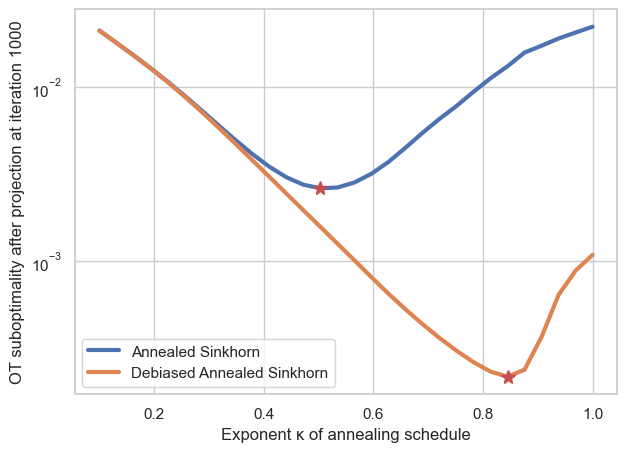

In [17]:
# -------- Error vs Scaling Exponent κ --------

sns.set(style="whitegrid")

# --- Widgets ---
setting_se = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_se_button = widgets.Button(description="Run Error vs κ")

# --- Callback ---
def run_error_vs_kappa(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_se, run_se_button]))
    # choose data based on setting
    if setting_se.value == 1:
        p_exp, q_exp, c_exp, OT_cost_exp = p1, q1, c1, cost_exact_1
    elif setting_se.value == 2:
        p_exp, q_exp, c_exp, OT_cost_exp = p2, q2, c2, cost_exact_2
    else: 
        p_exp, q_exp, c_exp, OT_cost_exp = p12, q12, c12, cost_exact_12

    # your exact parameters
    niter_se = 1000
    beta0_se = 10.0
    kappas = jnp.linspace(0.1, 1.0, 30)
    err_se1 = jnp.zeros(kappas.shape[0])
    err_se2 = jnp.zeros(kappas.shape[0])

    # main loop unchanged
    for idx, kap in enumerate(kappas):
        eps_sched = PolynomialEpsilon(target=jnp.array(1.0 / beta0_se), kappa=kap)
        _, e1 = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kap, beta0=beta0_se,
            debiased=False,
            eps_sched=eps_sched
        )
        err_se1 = err_se1.at[idx].set(e1[-1])

        _, e2 = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kap, beta0=beta0_se,
            debiased=True,
            eps_sched=eps_sched
        )
        err_se2 = err_se2.at[idx].set(e2[-1])

    # plot unchanged
    plt.figure(figsize=(7,5))
    plt.semilogy(kappas, err_se1, label='Annealed Sinkhorn', lw=3)
    plt.semilogy(kappas, err_se2, label='Debiased Annealed Sinkhorn', lw=3)
    plt.legend()
    plt.xlabel('Exponent κ of annealing schedule')
    plt.ylabel(f'OT suboptimality after projection at iteration {niter_se}')
    plt.grid(True)
    # highlight minima
    min1 = jnp.argmin(err_se1)
    min2 = jnp.argmin(err_se2)
    plt.plot(kappas[min1], err_se1[min1], 'r*', ms=10)
    plt.plot(kappas[min2], err_se2[min2], 'r*', ms=10)
    plt.show()

# --- Wire up and display ---
run_se_button.on_click(run_error_vs_kappa)
display(widgets.HBox([setting_se, run_se_button]))

### Error scaling as a function of $\beta_0$

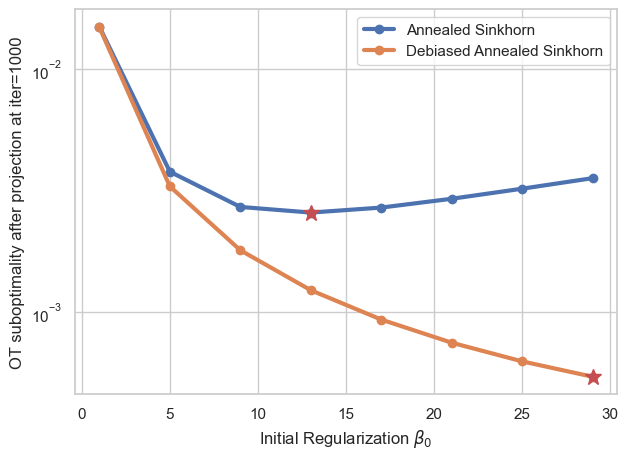

In [18]:
sns.set(style="whitegrid")

# --- Widgets ---
setting_se = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_se_button = widgets.Button(description="Run Error vs β₀")


# --- Callback ---
def run_error_vs_beta0(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_se, run_se_button]))
    # choose data based on setting
    if setting_se.value == 1:
        p_exp, q_exp, c_exp, OT_cost_exp = p1, q1, c1, cost_exact_1
    elif setting_se.value == 2:
        p_exp, q_exp, c_exp, OT_cost_exp = p2, q2, c2, cost_exact_2
    else:
        p_exp, q_exp, c_exp, OT_cost_exp = p12, q12, c12, cost_exact_12

    # fixed kappa, varying beta0
    niter_se = 1000
    kappa_fixed = 0.5
    beta0_list = jnp.arange(1, 31, 4)  # [1,6,11,16,21,26]
    err_b1 = jnp.zeros(beta0_list.shape[0])
    err_b2 = jnp.zeros(beta0_list.shape[0])

    # loop over beta0 values
    for idx, b0 in enumerate(beta0_list):
        eps_sched = PolynomialEpsilon(target=jnp.array(1.0 / b0), kappa=kappa_fixed)

        _, e1 = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kappa_fixed,
            beta0=b0,
            debiased=False,
            eps_sched=eps_sched
        )
        err_b1 = err_b1.at[idx].set(e1[-1])

        _, e2 = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kappa_fixed,
            beta0=b0,
            debiased=True,
            eps_sched=eps_sched
        )
        err_b2 = err_b2.at[idx].set(e2[-1])

    # plot
    plt.figure(figsize=(7,5))
    plt.semilogy(beta0_list, err_b1, label='Annealed Sinkhorn', lw=3, marker='o')
    plt.semilogy(beta0_list, err_b2, label='Debiased Annealed Sinkhorn', lw=3, marker='o')
    plt.legend()
    plt.xlabel(r'Initial Regularization $\beta_0$')
    plt.ylabel(f'OT suboptimality after projection at iter={niter_se}')
    plt.grid(True)
    # highlight minima
    min1 = int(jnp.argmin(err_b1))
    min2 = int(jnp.argmin(err_b2))
    plt.plot(beta0_list[min1], err_b1[min1], 'r*', ms=12)
    plt.plot(beta0_list[min2], err_b2[min2], 'r*', ms=12)
    plt.show()

# --- Wire up and display ---
run_se_button.on_click(run_error_vs_beta0)
display(widgets.HBox([setting_se, run_se_button]))

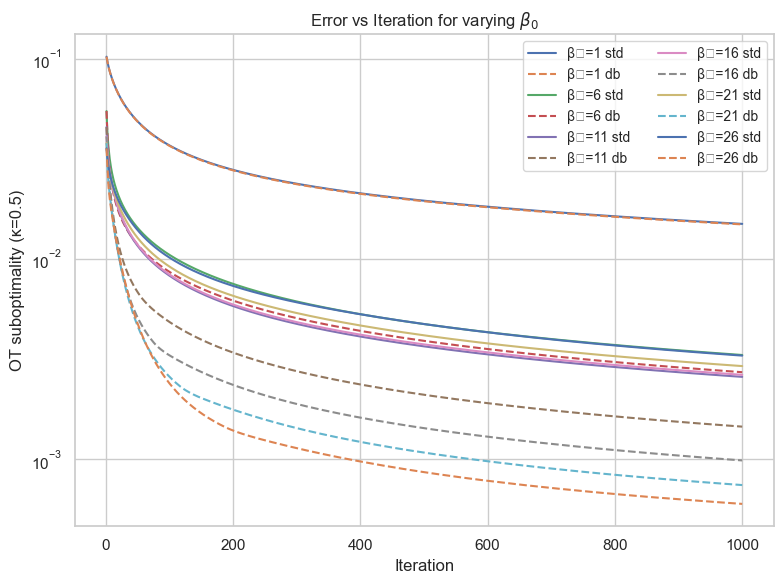

In [19]:
sns.set(style="whitegrid")

# --- Widgets ---
setting_se = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_se_button = widgets.Button(description="Run Error Dynamics")


# --- Callback ---
def run_error_dynamics(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_se, run_se_button]))
    # pick data
    if setting_se.value == 1:
        p_exp, q_exp, c_exp, OT_cost_exp = p1, q1, c1, cost_exact_1
    elif setting_se.value == 2:
        p_exp, q_exp, c_exp, OT_cost_exp = p2, q2, c2, cost_exact_2
    else:
        p_exp, q_exp, c_exp, OT_cost_exp = p12, q12, c12, cost_exact_12

    niter_se = 1000
    kappa_fixed = 0.5
    beta0_list = jnp.arange(1, 31, 5)  # [1,6,11,16,21,26]

    # allocate arrays: (num_beta, niter)
    err_std = jnp.zeros((beta0_list.shape[0], niter_se))
    err_db  = jnp.zeros_like(err_std)

    # run for each beta0
    for idx, b0 in enumerate(beta0_list):
        eps_sched = PolynomialEpsilon(target=jnp.array(1.0 / b0), kappa=kappa_fixed)

        _, e_std = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kappa_fixed,
            beta0=b0,
            debiased=False,
            eps_sched=eps_sched
        )
        _, e_db = sinkhorn_track(
            p_exp, q_exp, c_exp,
            niter=niter_se,
            OT_cost=OT_cost_exp,
            kappa=kappa_fixed,
            beta0=b0,
            debiased=True,
            eps_sched=eps_sched
        )
        err_std = err_std.at[idx].set(e_std)
        err_db  = err_db.at[idx].set(e_db)

    # plot all curves
    plt.figure(figsize=(8,6))
    its = jnp.arange(1, niter_se+1)
    for idx, b0 in enumerate(beta0_list):
        plt.semilogy(its, err_std[idx],  '-', label=f'β₀={int(b0)} std')
        plt.semilogy(its, err_db[idx],   '--', label=f'β₀={int(b0)} db')

    plt.xlabel('Iteration')
    plt.ylabel(f'OT suboptimality (κ={kappa_fixed})')
    plt.title(r'Error vs Iteration for varying $\beta_0$')
    plt.grid(True)
    plt.legend(ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()

# --- Wire up and display ---
run_se_button.on_click(run_error_dynamics)
display(widgets.HBox([setting_se, run_se_button]))

### 2-Polynomial versus piecewise constant schedules 

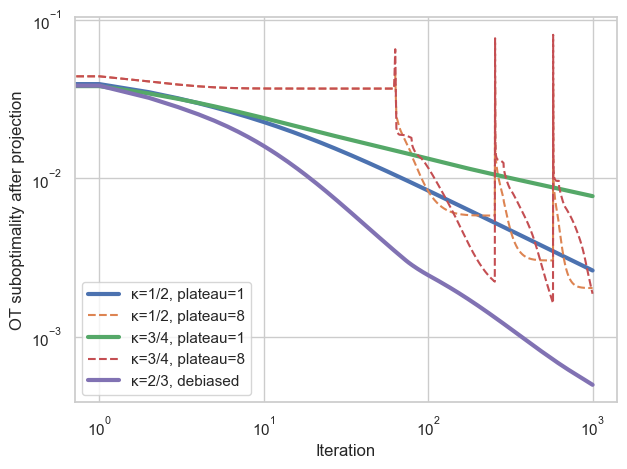

In [20]:

sns.set(style="whitegrid")

# --- Widget for choosing dataset setting ---
setting_pl = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_pl_button = widgets.Button(description="Run Plateau Comparison")


def run_plateau_comparison(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_pl, run_pl_button]))
    # select data based on widget
    if setting_pl.value == 1:
        p_sel, q_sel, c_sel, OT_sel =  p1, q1, c1, cost_exact_1
    elif setting_pl.value == 2:
        p_sel, q_sel, c_sel, OT_sel = p2, q2, c2, cost_exact_2
    else: 
        p_sel, q_sel, c_sel, OT_sel =  p12, q12, c12, cost_exact_12
    # parameters
    niter = 1000
    beta0 = 10.0

    # κ=1/2, plateau=1
    eps_12_pl1 = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=0.5)
    _, err1 = sinkhorn_track(
        p_sel, q_sel, c_sel,
        niter=niter,
        OT_cost=float(OT_sel),
        kappa=0.5, beta0=beta0,
        debiased=False,
        plateau_length=1,
        eps_sched=eps_12_pl1
    )
    # κ=1/2, plateau=8
    eps_12_pl8 = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=0.5)
    _, err2 = sinkhorn_track(
        p_sel, q_sel, c_sel,
        niter=niter,
        OT_cost=float(OT_sel),
        kappa=0.5, beta0=beta0,
        debiased=False,
        plateau_length=8,
        eps_sched=eps_12_pl8
    )

    # κ=3/4, plateau=1
    eps_34_pl1 = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=0.75)
    _, errb1 = sinkhorn_track(
        p_sel, q_sel, c_sel,
        niter=niter,
        OT_cost=float(OT_sel),
        kappa=0.75, beta0=beta0,
        debiased=False,
        plateau_length=1,
        eps_sched=eps_34_pl1
    )
    # κ=3/4, plateau=8
    eps_34_pl8 = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=0.75)
    _, errb2 = sinkhorn_track(
        p_sel, q_sel, c_sel,
        niter=niter,
        OT_cost=float(OT_sel),
        kappa=0.75, beta0=beta0,
        debiased=False,
        plateau_length=8,
        eps_sched=eps_34_pl8
    )

    # κ=2/3 debiased, plateau=1
    eps_23_db = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=2/3)
    _, errc1 = sinkhorn_track(
        p_sel, q_sel, c_sel,
        niter=niter,
        OT_cost=float(OT_sel),
        kappa=2/3, beta0=beta0,
        debiased=True,
        plateau_length=1,
        eps_sched=eps_23_db
    )

    # Plotting (unchanged)
    plt.figure(figsize=(7,5))
    plt.loglog(err1,  label='κ=1/2, plateau=1', lw=3)
    plt.semilogy(err2, '--', label='κ=1/2, plateau=8')
    plt.semilogy(errb1, label='κ=3/4, plateau=1', lw=3)
    plt.semilogy(errb2, '--', label='κ=3/4, plateau=8')
    plt.semilogy(errc1, label='κ=2/3, debiased', lw=3)
    plt.xlabel('Iteration')
    plt.ylabel('OT suboptimality after projection')
    plt.grid(True)
    plt.legend()
    plt.show()

# Wire it up and display
run_pl_button.on_click(run_plateau_comparison)
display(widgets.HBox([setting_pl, run_pl_button]))


### Symmetric sinkhorn comparison 

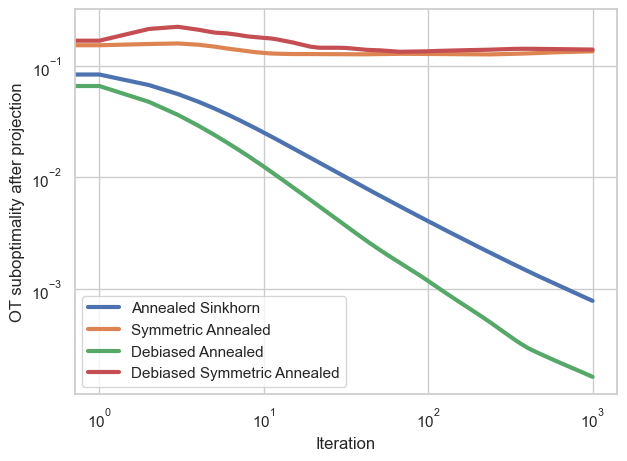

In [21]:
sns.set(style="whitegrid")

# --- Widgets for choosing dataset setting ---
setting_ss = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
run_ss_button = widgets.Button(description="Run Symmetric Comparison")


def run_symmetric_comparison(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_ss, run_ss_button]))
    # select data based on widget
    if setting_ss.value == 1:
        p_sel, q_sel, c_sel, OT_sel = p1, q1, c1, cost_exact_1
    elif setting_ss.value == 2:
        p_sel, q_sel, c_sel, OT_sel = p2, q2, c2, cost_exact_2
    else: 
        p_sel, q_sel, c_sel, OT_sel = p12, q12, c12, cost_exact_12
    # your parameters
    niter_sym = 1000
    beta_0 = 10.0
    beta0 = 10.0  # for debiased run
    kappa_an = 0.5
    kappa_db = 2/3

    # initialize same ε-schedule if needed (example)
    eps_sched_an_1 = PolynomialEpsilon(target=jnp.array(1.0 / beta_0), kappa=kappa_an)
    eps_sched_an_2 = PolynomialEpsilon(target=jnp.array(1.0 / beta_0), kappa=kappa_an)
    eps_sched_db_1 = PolynomialEpsilon(target=jnp.array(1.0 / beta0),  kappa=kappa_db)
    eps_sched_db_2 = PolynomialEpsilon(target=jnp.array(1.0 / beta0),  kappa=kappa_db)

    # runs as before
    _, err_as   = sinkhorn_track(  p_sel, q_sel, c_sel,
                                    niter=niter_sym, OT_cost=float(OT_sel),
                                    kappa=kappa_an, beta0=beta_0, debiased=False,
                                    eps_sched=eps_sched_an_1)
    _, err_sym  = symmetric_sinkhorn_track( p_sel, q_sel, c_sel,
                                            niter=niter_sym, OT_cost=float(OT_sel),
                                            kappa=kappa_an, beta0=beta_0, debiased=False,
                                            eps_sched=eps_sched_an_2)
    _, err_as_d = sinkhorn_track(  p_sel, q_sel, c_sel,
                                    niter=niter_sym, OT_cost=float(OT_sel),
                                    kappa=kappa_db, beta0=beta0, debiased=True,
                                    eps_sched=eps_sched_db_1)
    _, err_sym_d= symmetric_sinkhorn_track( p_sel, q_sel, c_sel,
                                            niter=niter_sym, OT_cost=float(OT_sel),
                                            kappa=kappa_db, beta0=beta_0, debiased=True,
                                            eps_sched=eps_sched_db_2)

    # plotting unchanged
    plt.figure(figsize=(7,5))

    plt.loglog(err_as,   label='Annealed Sinkhorn',             lw=3)
    plt.loglog(err_sym,   label='Symmetric Annealed',             lw=3)
    plt.loglog(err_as_d,   label='Debiased Annealed',             lw=3)
    plt.loglog(err_sym_d, label='Debiased Symmetric Annealed',    lw=3)
    plt.xlabel('Iteration')
    plt.ylabel('OT suboptimality after projection')
    plt.grid(True)
    plt.legend()
    plt.show()

run_ss_button.on_click(run_symmetric_comparison)
display(widgets.HBox([setting_ss, run_ss_button]))

In this experiment, the **symmetric version** runs more slowly, and **debiasing does not bring any clear improvement**.

### 3- Sinkhorn path observation 

The solution to the proxy path, for given parameters $\alpha$ and $\beta$: $$\min \langle c,\pi\rangle +\frac{1}{\alpha}KL(\pi^\top \mathbf{1}|p)+\iota_{\{q\}}(\pi^\top \mathbf{1}) +\frac{1}{\beta}KL(\pi,\pi^{\mathbf{ref}})$$
where $\pi^{\mathbf{ref}}=(mn)^{-1}\mathbf{1}\mathbf{1}^\top$
Alternate maximization on the dual problem is performed . The equations are as follows:
$$
K=e^{-\beta c}\pi^{\mathbf{ref}}, \quad a_{t+1} = \Big( \frac{p}{Kb_t}\Big)^{\beta/(\beta+\alpha)}, \quad b_{t+1} = \frac{q}{K^\top a_{t+1}}.
$$
and we return the plan $\pi_t=\mathrm{diag}(a_t)K\mathrm{diag}(b_t)$. 

In [22]:
def proxy_path_step(p: jnp.ndarray, q: jnp.ndarray, c: jnp.ndarray,
                     alpha: float, beta: float,
                     u_init: jnp.ndarray, v_init: jnp.ndarray,
                     niter: int = 10) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Single proxy path iteration block (warm-started).
    Returns: transport plan, updated u, v
    """
    u, v = u_init, v_init
    lp = jnp.log(p)
    lq = jnp.log(q)
    theta = beta / (alpha + beta)
    for _ in range(niter):
        # update u
        temp1 = v + lq - beta * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        u = (-(stab1.flatten()) - jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1))) * theta + (theta - 1) * lp
        # update v
        temp2 = u + lp - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        v = -(stab2.flatten()) - jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0))
    plan = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c)
    return plan, u, v




In [23]:
def proxy_path(p: jnp.ndarray, q: jnp.ndarray, c: jnp.ndarray,
               alphas: jnp.ndarray, betas: jnp.ndarray) -> jnp.ndarray:
    """
    Build proxy path over schedule defined by alphas, betas.
    """
    T = alphas.shape[0]
    m, n = p.shape[0], q.shape[0]
    path = jnp.zeros((T, m, n))
    u = jnp.zeros(m)
    v = jnp.zeros(n)
    niter = 100
    for t in range(T):
        plan_t, u, v = proxy_path_step(p, q, c,
                                      float(alphas[t]), float(betas[t]),
                                      u, v, niter=niter)
        path = path.at[t].set(plan_t)
        niter = 50
    return path




In [24]:
def sinkhorn_path(p: jnp.ndarray, q: jnp.ndarray, c: jnp.ndarray,
                   niter: int = 100, kappa: float = 0.0, beta0: float = 1.0,
                   debiased: bool = True, eps_sched: PolynomialEpsilon = None) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute Sinkhorn path and schedule betas (without projection).
    Returns: path[T, m, n], betas[T]
    """
    m, n = p.shape[0], q.shape[0]
    u = jnp.zeros(m)
    v = jnp.zeros(n)
    lp = jnp.log(p)
    lq = jnp.log(q)
    path = jnp.zeros((niter, m, n))
    betas = jnp.zeros(niter)
    beta = beta0
    for t in range(niter):  
        betas = betas.at[t].set(beta)
      
        # dual update 1
        if debiased:
            inv_eps_prev = 1.0 / eps_sched(t-1) if t > 0 else 0.0
            deb = (1/ eps_sched(t) - inv_eps_prev) / (1/ eps_sched(t)) * u
            temp1 = (lq + v - beta * c) - deb[:, None]
        else:
            temp1 = v + lq - beta * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        u = -stab1.flatten() - jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1))
        # update beta
        beta = 1/eps_sched(t+1)
        # dual update 2
        temp2 = u[:, None] + lp[:, None] - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        v = -stab2.flatten() - jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0))
        # transport plan
        path_t = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c)
        path = path.at[t].set(path_t)
    return path, betas



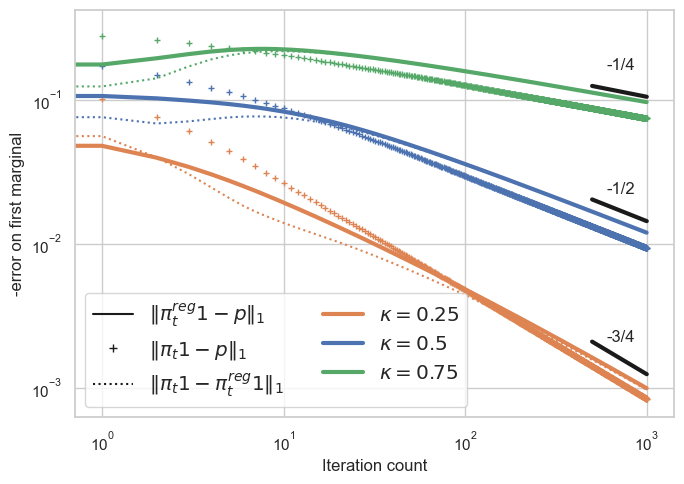

In [25]:
sns.set(style="whitegrid")

# Widgets for choosing dataset and debiased flag
setting_pp = widgets.Dropdown(
    options=[('Geometric point cloud (paper)', 1), ('Unstructured random', 2), ('Geometric point cloud (spiral to grid)', 3)],
    value=1,
    description='Setting:'
)
debiased_pp = widgets.Checkbox(
    value=False,
    description='Debiased'
)
run_pp_button = widgets.Button(description="Run Proxy vs Optimal")

def run_proxy_vs_optimal(_):
    clear_output(wait=True)
    display(widgets.HBox([setting_pp, debiased_pp, run_pp_button]))
    # select data
    if setting_pp.value == 1:
        p_sel, q_sel, c_sel, OT_sel = p1, q1, c1, cost_exact_1
    elif setting_pp.value == 2:
        p_sel, q_sel, c_sel, OT_sel = p2, q2, c2, cost_exact_2
    else: 
        p_sel, q_sel, c_sel, OT_sel = p12, q12, c12, cost_exact_12

    niter = 1000
    beta0 = 10.0
    schedules = [0.25, 0.5, 0.75]

    opt_paths = []
    prox_paths = []
    for kappa in schedules:
        # build schedule per kappa
        eps_sched = PolynomialEpsilon(target=jnp.array(1.0/beta0), kappa=kappa)

        # optimal path
        path_opt, betas = sinkhorn_path(
            p_sel, q_sel, c_sel,
            niter=niter,
            kappa=kappa,
            beta0=beta0,
            debiased=debiased_pp.value,
            eps_sched=eps_sched
        )
        alphas = betas[1:] - betas[:-1]

        # proxy path
        path_proxy = proxy_path(p_sel, q_sel, c_sel, alphas, betas[:-1])

        opt_paths.append(path_opt)
        prox_paths.append(path_proxy)

    # compute marginal errors
    errors = {}
    for idx, kappa in enumerate(schedules):
        opt = opt_paths[idx]
        prox = prox_paths[idx]
        err_prox = jnp.array([
            jnp.sum(jnp.abs(jnp.sum(prox[t], axis=1) - p_sel))
            for t in range(niter-1)
        ])
        err_opt = jnp.array([
            jnp.sum(jnp.abs(jnp.sum(opt[t], axis=1) - p_sel))
            for t in range(niter-1)
        ])
        err_diff = jnp.array([
            jnp.sum(jnp.abs(jnp.sum(opt[t], axis=1) - jnp.sum(prox[t], axis=1)))
            for t in range(niter-1)
        ])
        errors[kappa] = (err_prox, err_opt, err_diff)

    # plotting
    plt.figure(figsize=(7,5))
    # dummy for legend
    plt.loglog([errors[0.5][0][0]], 'k', label=r'$\|\pi_t^{reg}1 - p\|_1$')
    plt.plot([errors[0.5][1][0]], 'k+', label=r'$\|\pi_t1 - p\|_1$')
    plt.plot([errors[0.5][2][0]], ':k', label=r'$\|\pi_t1 - \pi_t^{reg}1\|_1$')

    colors = {0.25:'C1', 0.5:'C0', 0.75:'C2'}
    for kappa in schedules:
        err_prox, err_opt, err_diff = errors[kappa]
        plt.loglog(err_prox, label=fr'$\kappa={kappa}$', color=colors[kappa], lw=3)
        plt.loglog(err_opt, f'{colors[kappa]}+', markersize=4)
        plt.loglog(err_diff, f':{colors[kappa]}')

    # slope lines
    its = jnp.arange(500, niter+1, 10)
    plt.text(600, 0.16, '-1/4')
    plt.plot(its, its**(-0.25)/1.7, 'k', lw=3)
    plt.text(600, 0.022, '-1/2')
    plt.plot(its, its**(-0.5)/2.2, 'k', lw=3)
    plt.text(600, 0.0021, '-3/4')
    plt.plot(its, its**(-0.75)/4.5, 'k', lw=3)

    plt.legend(ncol=2, fontsize='large')
    plt.grid(True)
    plt.xlabel('Iteration count')
    plt.ylabel('-error on first marginal')
    plt.tight_layout()
    plt.show()

# Wire up and display
run_pp_button.on_click(run_proxy_vs_optimal)
display(widgets.HBox([setting_pp, debiased_pp, run_pp_button]))




Under the “geometric” cost setup (from the paper):

- The regularization path $\| \pi^{\text{reg}}_t \mathbf{1} - p \|_1$ is expected to follow the rate $\Theta(t^{\kappa - 1})$, and it closely matches the actual optimization path $\| \pi_t \mathbf{1} - p \|_1$.

- The gap between both paths (shown as dotted lines in the plots) is much smaller—more than **an order of magnitude** less.


# Conclusion

We inspire from the following [repository](https://github.com/lchizat/annealed-sinkhorn/blob/main/annealed-sinkhorn.ipynb) in the elaboration of this tutorial.


To ensure compatibility between different JAX versions and the packages used in this tutorial, we adopted the following configuration when elaborating the tutorial.

- `jax==0.4.38`
- `jaxlib==0.4.38`
- `flax==0.10.2`
- `chex==0.1.86`
- `optax==0.2.4`
